In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import f_regression, SelectKBest, chi2
import statsmodels.api as sm
import numpy as np
from statsmodels.formula.api import ols
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report

In [3]:
data = pd.read_csv (r'data_clean_4_21.csv')

## Data processing

In [4]:
# remove those without fips_code
data.dropna(subset = ["fips_code"], inplace=True)
data.dropna(subset = ["ICU.Bed.Occupancy.Rate"], inplace=True)
data.dropna(subset = ["population_20"], inplace=True)
#data.isnull().sum()
X = data.drop(['fips_code', 'date', 'county', 'State', 'Staffed.All.Beds', 'Staffed.ICU.Beds', 'Licensed.All.Beds',
       'All.Bed.Occupancy.Rate', 'ICU.Bed.Occupancy.Rate', 'Population', 'Population_2010',
       'Population..20..', 'Population..65..',
       'Staffed.All.Beds..Per.1000.People.',
       'Staffed.All.Beds..Per.1000.Adults..20...',
       'Staffed.All.Beds..Per.1000.Elderly..65...',
       'Staffed.ICU.Beds..Per.1000.People.',
       'Staffed.ICU.Beds..Per.1000.Adults..20...',
       'Staffed.ICU.Beds..Per.1000.Elderly..65...',
       'Licensed.All.Beds..Per.1000.People.',
       'Licensed.All.Beds..Per.1000.Adults..20...',
       'Licensed.All.Beds..Per.1000.Elderly..65...', 'county_x', 'cases', 'deaths', 'County_Name', 'Area_name'], axis = 1)
X['state'] = X.state.factorize()[0]
X['Description'] = X.Description.factorize()[0]
X['peopleinpoverty2018'] = X.peopleinpoverty2018.factorize()[0]
X['medianhouseholdincome'] = X.medianhouseholdincome.factorize()[0]
Y_c = data['cases']
Y_d = data['deaths']
X_new = X.drop(['population'], axis = 1)

## Feature selection

In [5]:
X_train, X_valid, y_train, y_valid = train_test_split(X_new, Y_c, test_size = 0.7, random_state = 1)
rf = RandomForestClassifier() 
rf.fit(X_train, y_train) 
rf.score(X_valid, y_valid)
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
feature_importances

,importance
all_bed_occupancy_rate,0.055628
medianhouseholdincome,0.055496
population_20,0.054870
peopleinpoverty2018,0.053615
icu_bed_occupancy_rate,0.051981
population_65,0.050668
licensed_all_beds_.per_1000_adults_20..,0.049807
staffed_icu_beds_.per_1000_people.,0.049259
staffed_icu_beds_.per_1000_elderly_65..,0.049128
licensed_all_beds_.per_1000_elderly_65..,0.048509


## Regression Models

In [6]:
X_c = X[['population_20', 'peopleinpoverty2018', 'medianhouseholdincome', 'icu_bed_occupancy_rate', 'all_bed_occupancy_rate']]


X_train, X_test, y_train, y_test = train_test_split(X_c, Y_c, test_size=0.3)

In [7]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [8]:
#create new a knn model
knn = KNeighborsClassifier()
#create a dictionary of all values we want to test for n_neighbors
params_knn = {'n_neighbors': np.arange(1, 25)}
#use gridsearch to test all values for n_neighbors
knn_gs = GridSearchCV(knn, params_knn, cv=5)
#fit model to training data
knn_gs.fit(X_train, y_train)
#save best model
knn_best = knn_gs.best_estimator_
#check best n_neigbors value
print(knn_gs.best_params_)
#create a new random forest classifier
rf = RandomForestClassifier()
#create a dictionary of all values we want to test for n_estimators
params_rf = {'n_estimators': [50, 100, 200]}
#use gridsearch to test all values for n_estimators
rf_gs = GridSearchCV(rf, params_rf, cv=5)
#fit model to training data
rf_gs.fit(X_train, y_train)
#save best model
rf_best = rf_gs.best_estimator_
#check best n_estimators value
print(rf_gs.best_params_)
#create a new logistic regression model
log_reg = LogisticRegression()
#fit the model to the training data
log_reg.fit(X_train, y_train)

/opt/anaconda3/envs/Computational_methods/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


{'n_neighbors': 8}


/opt/anaconda3/envs/Computational_methods/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


{'n_estimators': 100}


/opt/anaconda3/envs/Computational_methods/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [9]:
print('knn: {}'.format(knn_best.score(X_test, y_test)))
print('rf: {}'.format(rf_best.score(X_test, y_test)))
print('log_reg: {}'.format(log_reg.score(X_test, y_test)))

knn: 0.03170731707317073
rf: 0.01951219512195122
log_reg: 0.012195121951219513


In [10]:
from sklearn.ensemble import GradientBoostingRegressor
gbrt = GradientBoostingRegressor(max_depth=5, 
                                 n_estimators=3, 
                                 learning_rate=1.0)
gbrt.fit(X_train, y_train)
gbrt.score(X_test, y_test)
mse = mean_squared_error(y_test, gbrt.predict(X_test))
print("MSE: %.4f" % mse)

MSE: 1477304.1207


In [11]:
# random forest MSE
mse = mean_squared_error(y_test, rf_best.predict(X_test))
print("MSE: %.4f" % mse)

MSE: 1870824.3805


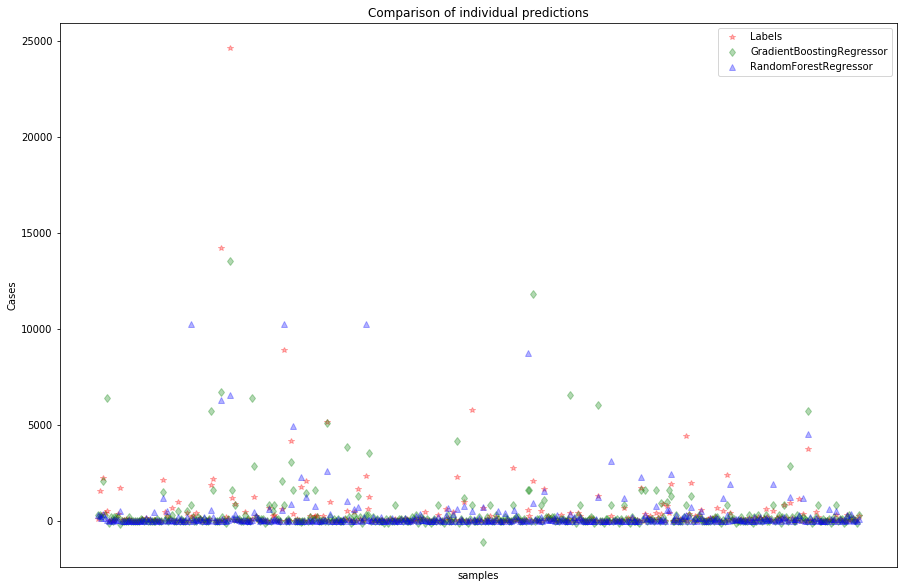

In [12]:
plt.figure(figsize=(15,10))
plt.plot(np.arange(y_test.shape[0]), y_test, 'r*', label='Labels', alpha=0.3)
plt.plot(np.arange(y_test.shape[0]), gbrt.predict(X_test), 'gd', label='GradientBoostingRegressor', alpha=0.3)
plt.plot(np.arange(y_test.shape[0]), rf_best.predict(X_test), 'b^', label='RandomForestRegressor', alpha=0.3)

plt.tick_params(axis='x', which='both', bottom=False, top=False,
                labelbottom=False)
plt.ylabel('Cases')
plt.xlabel('samples')
plt.legend(loc="best")
plt.title('Comparison of individual predictions')
plt.show()

## Selected variables

In [16]:
X.columns

Index(['state', 'staffed_all_beds', 'staffed_icu_beds', 'licensed_all_beds',
       'all_bed_occupancy_rate', 'icu_bed_occupancy_rate', 'population',
       'population_20', 'population_65', 'staffed_all_beds_.per_1000_people.',
       'staffed_all_beds_.per_1000_adults_20..',
       'staffed_all_beds_.per_1000_elderly_65..',
       'staffed_icu_beds_.per_1000_people.',
       'staffed_icu_beds_.per_1000_adults_20..',
       'staffed_icu_beds_.per_1000_elderly_65..',
       'licensed_all_beds_per_1000_people',
       'licensed_all_beds_.per_1000_adults_20..',
       'licensed_all_beds_.per_1000_elderly_65..', 'RUCC_2013', 'Description',
       'Rural.urban_Continuum_Code_2013', 'Urban_Influence_Code_2013',
       'peopleinpoverty2018', 'medianhouseholdincome'],
      dtype='object')

In [17]:
X_d = X[['state', 'all_bed_occupancy_rate', 'icu_bed_occupancy_rate', 'Description', 'peopleinpoverty2018', 'medianhouseholdincome']]


X_train, X_test, y_train, y_test = train_test_split(X_d, Y_d, test_size=0.3)

In [18]:
#create new a knn model
knn = KNeighborsClassifier()
#create a dictionary of all values we want to test for n_neighbors
params_knn = {'n_neighbors': np.arange(1, 25)}
#use gridsearch to test all values for n_neighbors
knn_gs = GridSearchCV(knn, params_knn, cv=5)
#fit model to training data
knn_gs.fit(X_train, y_train)
#save best model
knn_best = knn_gs.best_estimator_
#check best n_neigbors value
print(knn_gs.best_params_)
#create a new random forest classifier
rf = RandomForestClassifier()
#create a dictionary of all values we want to test for n_estimators
params_rf = {'n_estimators': [50, 100, 200]}
#use gridsearch to test all values for n_estimators
rf_gs = GridSearchCV(rf, params_rf, cv=5)
#fit model to training data
rf_gs.fit(X_train, y_train)
#save best model
rf_best = rf_gs.best_estimator_
#check best n_estimators value
print(rf_gs.best_params_)
#create a new logistic regression model
log_reg = LogisticRegression()
#fit the model to the training data
log_reg.fit(X_train, y_train)

/opt/anaconda3/envs/Computational_methods/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


{'n_neighbors': 21}


/opt/anaconda3/envs/Computational_methods/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


{'n_estimators': 200}


/opt/anaconda3/envs/Computational_methods/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [19]:
print('knn: {}'.format(knn_best.score(X_test, y_test)))
print('rf: {}'.format(rf_best.score(X_test, y_test)))
print('log_reg: {}'.format(log_reg.score(X_test, y_test)))

knn: 0.348780487804878
rf: 0.32926829268292684
log_reg: 0.35609756097560974


In [20]:
from sklearn.ensemble import GradientBoostingRegressor
gbrt = GradientBoostingRegressor(max_depth=5, 
                                 n_estimators=3, 
                                 learning_rate=1.0)
gbrt.fit(X_train, y_train)
gbrt.score(X_test, y_test)
mse = mean_squared_error(y_test, gbrt.predict(X_test))
print("MSE: %.4f" % mse)

MSE: 16502.6472


In [21]:
# random forest MSE
mse = mean_squared_error(y_test, rf_best.predict(X_test))
print("MSE: %.4f" % mse)

MSE: 6522.7415


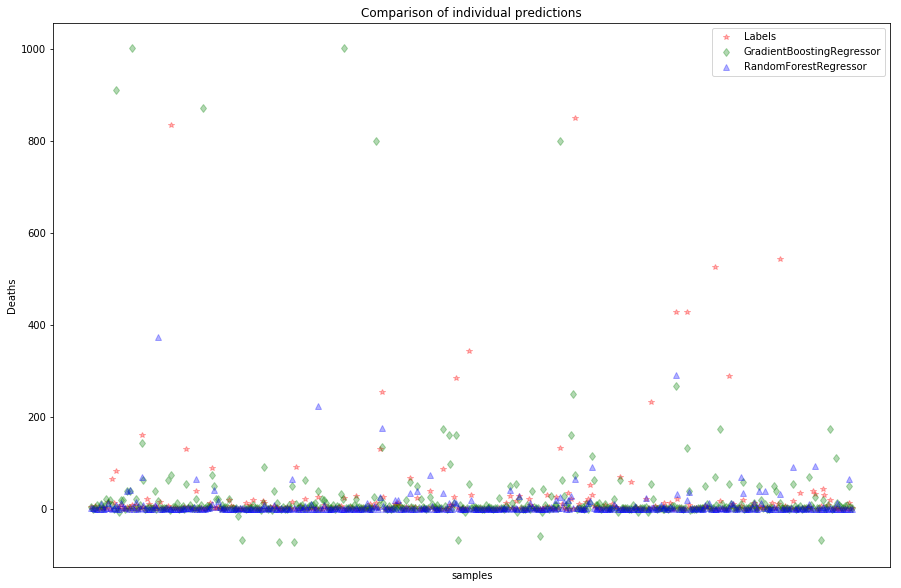

In [22]:
plt.figure(figsize=(15,10))
plt.plot(np.arange(y_test.shape[0]), y_test, 'r*', label='Labels', alpha=0.3)
plt.plot(np.arange(y_test.shape[0]), gbrt.predict(X_test), 'gd', label='GradientBoostingRegressor', alpha=0.3)
plt.plot(np.arange(y_test.shape[0]), rf_best.predict(X_test), 'b^', label='RandomForestRegressor', alpha=0.3)

plt.tick_params(axis='x', which='both', bottom=False, top=False,
                labelbottom=False)
plt.ylabel('Deaths')
plt.xlabel('samples')
plt.legend(loc="best")
plt.title('Comparison of individual predictions')
plt.show()